# Cambridge Bicycle Crashes Visualization

This notebook provides comprehensive visualizations of the cleaned Cambridge bicycle crash data, including interactive maps, temporal patterns, and key insights for safety analysis.

## Dataset Overview
- **Source**: Cleaned Cambridge Police Department Crash Data
- **Focus**: Bicycle-related crashes with coordinates
- **Time Period**: 2015-2024
- **Purpose**: Identify high-risk areas and patterns for safety improvements


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium import plugins
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Pandas version: 2.3.2
NumPy version: 2.3.3


## 1. Load and Explore Cleaned Data


In [3]:
# Load the cleaned bicycle crashes dataset
data_path = './data/processed/bicycle_crashes_cleaned.csv'
df = pd.read_csv(data_path)

print(f"Cleaned dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display basic info
print("\n" + "="*50)
print("CLEANED DATASET OVERVIEW")
print("="*50)
print(f"Total bicycle crashes: {len(df):,}")
print(f"Date range: {df['Date Time'].min()} to {df['Date Time'].max()}")
print(f"Unique streets: {df['Street Name Cleaned'].nunique():,}")
print(f"Unique intersections: {df['Intersection_ID'].nunique():,}")
print(f"Records with coordinates: {len(df.dropna(subset=['Latitude', 'Longitude'])):,}")

# Show sample of the data
print(f"\nSAMPLE OF CLEANED DATA:")
print("="*30)
sample_columns = ['Date Time', 'Street Name Cleaned', 'Cross Street Cleaned', 'Intersection_ID', 
                  'Latitude', 'Longitude', 'Manner of Collision', 'Weather Condition 1']
print(df[sample_columns].head())


Cleaned dataset loaded successfully!
Shape: (552, 38)
Columns: 38
Memory usage: 1.14 MB

CLEANED DATASET OVERVIEW
Total bicycle crashes: 552
Date range: 2015-01-05 09:17:00 to 2025-08-24 10:40:00
Unique streets: 96
Unique intersections: 157
Records with coordinates: 552

SAMPLE OF CLEANED DATA:
             Date Time   Street Name Cleaned Cross Street Cleaned  \
0  2025-08-24 10:40:00  MASSACHUSETTS AVENUE         BEECH STREET   
1  2025-08-22 16:00:00  MASSACHUSETTS AVENUE         STATE STREET   
2  2025-08-16 11:55:00  MASSACHUSETTS AVENUE    LANDSDOWNE STREET   
3  2025-08-15 21:51:00  MASSACHUSETTS AVENUE                  NaN   
4  2025-08-11 15:30:00             QUINCY ST                  NaN   

                              Intersection_ID   Latitude  Longitude  \
0       BEECH STREET_AND_MASSACHUSETTS AVENUE  42.369333 -71.110750   
1       MASSACHUSETTS AVENUE_AND_STATE STREET  42.369333 -71.110750   
2  LANDSDOWNE STREET_AND_MASSACHUSETTS AVENUE  42.369333 -71.110750   
3    

In [4]:
# Convert Date Time to datetime and add derived features
df['Date Time'] = pd.to_datetime(df['Date Time'])

# Add additional temporal features
df['Year'] = df['Date Time'].dt.year
df['Month'] = df['Date Time'].dt.month
df['Day'] = df['Date Time'].dt.day
df['Hour'] = df['Date Time'].dt.hour
df['Day_of_Week_Num'] = df['Date Time'].dt.dayofweek
df['Is_Weekend'] = df['Day_of_Week_Num'].isin([5, 6])
df['Is_Rush_Hour'] = df['Hour'].isin([7, 8, 9, 16, 17, 18])

# Create season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

# Show top intersections and streets
print("TOP 10 INTERSECTIONS WITH BICYCLE CRASHES:")
print("="*50)
top_intersections = df['Intersection_ID'].value_counts().head(10)
print(top_intersections)

print(f"\nTOP 10 STREETS WITH BICYCLE CRASHES:")
print("="*45)
top_streets = df['Street Name Cleaned'].value_counts().head(10)
print(top_streets)

# Show crash patterns by time
print(f"\nCRASH PATTERNS BY TIME:")
print("="*30)
print("By Year:")
yearly_crashes = df['Year'].value_counts().sort_index()
print(yearly_crashes)

print("\nBy Season:")
seasonal_crashes = df['Season'].value_counts()
print(seasonal_crashes)

print("\nBy Day of Week:")
daily_crashes = df['Day of Week'].value_counts()
print(daily_crashes)


TOP 10 INTERSECTIONS WITH BICYCLE CRASHES:
Intersection_ID
MASSACHUSETTS AVENUE                      137
CAMBRIDGE STREET                           35
BROADWAY                                   29
HAMPSHIRE STREET                           25
ALBANY STREET_AND_MASSACHUSETTS AVENUE     14
VASSAR ST                                  10
JFK STREET                                  9
PROSPECT STREET                             9
MAIN STREET                                 8
COLUMBIA ST                                 7
Name: count, dtype: int64

TOP 10 STREETS WITH BICYCLE CRASHES:
Street Name Cleaned
MASSACHUSETTS AVENUE    256
CAMBRIDGE STREET         35
BROADWAY                 29
HAMPSHIRE STREET         25
OXFORD STREET            13
VASSAR ST                11
ALBANY STREET             9
JFK STREET                9
PROSPECT STREET           9
VASSAR STREET             8
Name: count, dtype: int64

CRASH PATTERNS BY TIME:
By Year:
Year
2015    45
2016    68
2017    65
2018    53
2019    

## 2. Interactive Map Visualization


In [5]:
# Create interactive map of bicycle crashes
print("CREATING INTERACTIVE MAP:")
print("="*30)

# Calculate center point for the map
center_lat = df['Latitude'].mean()
center_lon = df['Longitude'].mean()

print(f"Map center: ({center_lat:.4f}, {center_lon:.4f})")

# Create base map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=13,
    tiles='OpenStreetMap'
)

# Add bicycle crash markers with color coding by year
for idx, row in df.iterrows():
    # Color code by year
    year = row['Date Time'].year
    if year >= 2023:
        color = 'red'
    elif year >= 2021:
        color = 'orange'
    elif year >= 2019:
        color = 'yellow'
    else:
        color = 'green'
    
    # Create popup text
    popup_text = f"""
    <b>Bicycle Crash</b><br>
    Date: {row['Date Time'].strftime('%Y-%m-%d %H:%M')}<br>
    Street: {row['Street Name Cleaned']}<br>
    Cross Street: {row['Cross Street Cleaned']}<br>
    Intersection: {row['Intersection_ID']}<br>
    Collision: {row['Manner of Collision']}<br>
    Weather: {row['Weather Condition 1']}<br>
    """
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        popup=folium.Popup(popup_text, max_width=300),
        color='black',
        fillColor=color,
        fillOpacity=0.7,
        weight=1
    ).add_to(m)

# Add heatmap layer
heat_data = [[row['Latitude'], row['Longitude']] for idx, row in df.iterrows()]
plugins.HeatMap(heat_data, name='Bicycle Crash Heatmap').add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save and display map
m.save('bicycle_crashes_interactive_map.html')
print("Interactive map saved as 'bicycle_crashes_interactive_map.html'")
print(f"Map shows {len(df)} bicycle crashes with coordinates")

# Display the map
display(m)


CREATING INTERACTIVE MAP:
Map center: (42.3720, -71.1085)
Interactive map saved as 'bicycle_crashes_interactive_map.html'
Map shows 552 bicycle crashes with coordinates


## 3. Temporal Pattern Visualizations


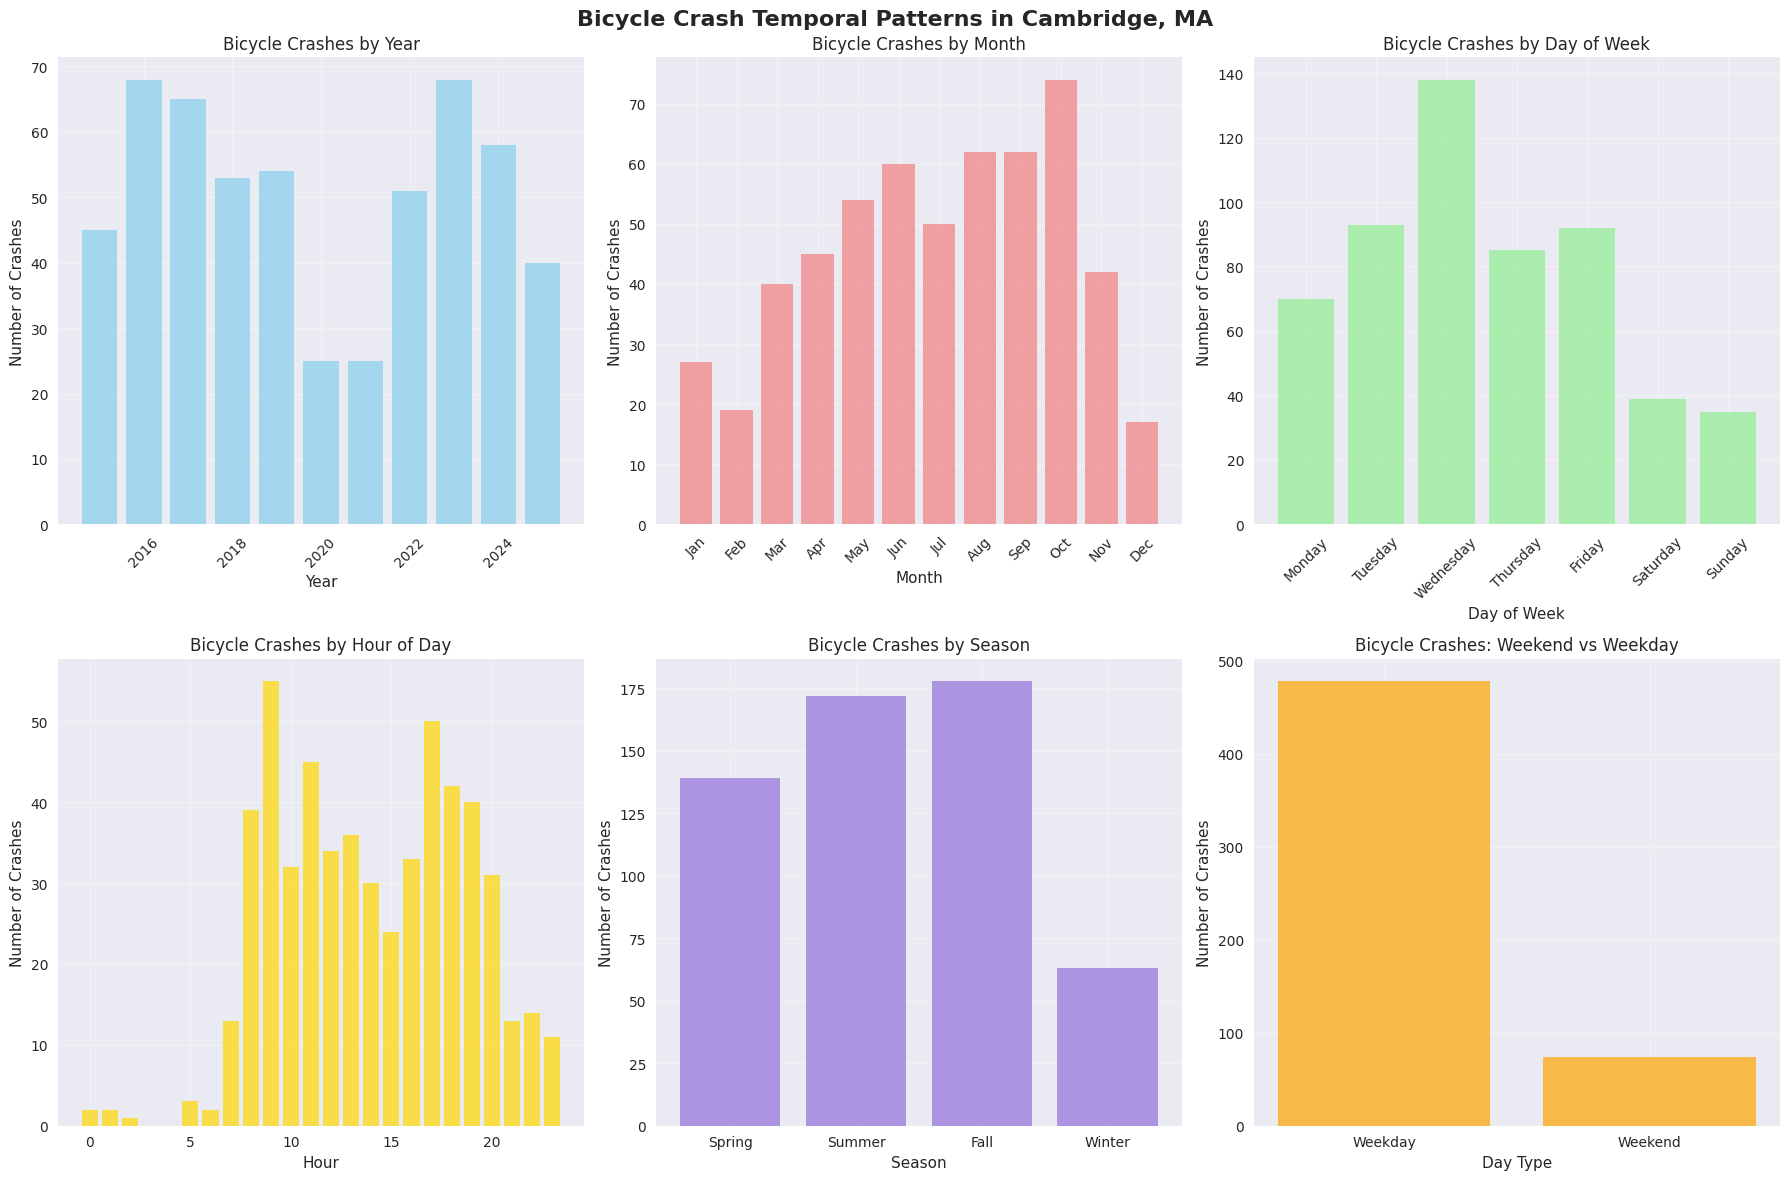

TEMPORAL PATTERN SUMMARY:
Peak year: 2016 (68 crashes)
Peak month: Oct (74 crashes)
Peak day: Wednesday (138 crashes)
Peak hour: 9:00 (55 crashes)
Peak season: Fall (178 crashes)
Weekend crashes: 74 (13.4%)
Weekday crashes: 478 (86.6%)


In [6]:
# Create comprehensive temporal visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Bicycle Crash Temporal Patterns in Cambridge, MA', fontsize=16, fontweight='bold')

# 1. Crashes by Year
yearly_crashes = df['Year'].value_counts().sort_index()
axes[0, 0].bar(yearly_crashes.index, yearly_crashes.values, color='skyblue', alpha=0.7)
axes[0, 0].set_title('Bicycle Crashes by Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Crashes')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# 2. Crashes by Month
monthly_crashes = df['Month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 1].bar(month_names, monthly_crashes.values, color='lightcoral', alpha=0.7)
axes[0, 1].set_title('Bicycle Crashes by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Crashes')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Crashes by Day of Week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_crashes = df['Day of Week'].value_counts()
daily_crashes = daily_crashes.reindex(day_order)
axes[0, 2].bar(daily_crashes.index, daily_crashes.values, color='lightgreen', alpha=0.7)
axes[0, 2].set_title('Bicycle Crashes by Day of Week')
axes[0, 2].set_xlabel('Day of Week')
axes[0, 2].set_ylabel('Number of Crashes')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3)

# 4. Crashes by Hour of Day
hourly_crashes = df['Hour'].value_counts().sort_index()
axes[1, 0].bar(hourly_crashes.index, hourly_crashes.values, color='gold', alpha=0.7)
axes[1, 0].set_title('Bicycle Crashes by Hour of Day')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Number of Crashes')
axes[1, 0].grid(True, alpha=0.3)

# 5. Crashes by Season
seasonal_crashes = df['Season'].value_counts()
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
seasonal_crashes = seasonal_crashes.reindex(season_order)
axes[1, 1].bar(seasonal_crashes.index, seasonal_crashes.values, color='mediumpurple', alpha=0.7)
axes[1, 1].set_title('Bicycle Crashes by Season')
axes[1, 1].set_xlabel('Season')
axes[1, 1].set_ylabel('Number of Crashes')
axes[1, 1].grid(True, alpha=0.3)

# 6. Weekend vs Weekday
weekend_crashes = df['Is_Weekend'].value_counts()
weekend_labels = ['Weekday', 'Weekend']
axes[1, 2].bar(weekend_labels, weekend_crashes.values, color='orange', alpha=0.7)
axes[1, 2].set_title('Bicycle Crashes: Weekend vs Weekday')
axes[1, 2].set_xlabel('Day Type')
axes[1, 2].set_ylabel('Number of Crashes')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("TEMPORAL PATTERN SUMMARY:")
print("="*30)
print(f"Peak year: {yearly_crashes.idxmax()} ({yearly_crashes.max()} crashes)")
print(f"Peak month: {month_names[monthly_crashes.idxmax()-1]} ({monthly_crashes.max()} crashes)")
print(f"Peak day: {daily_crashes.idxmax()} ({daily_crashes.max()} crashes)")
print(f"Peak hour: {hourly_crashes.idxmax()}:00 ({hourly_crashes.max()} crashes)")
print(f"Peak season: {seasonal_crashes.idxmax()} ({seasonal_crashes.max()} crashes)")
print(f"Weekend crashes: {weekend_crashes.get(True, 0)} ({weekend_crashes.get(True, 0)/len(df)*100:.1f}%)")
print(f"Weekday crashes: {weekend_crashes.get(False, 0)} ({weekend_crashes.get(False, 0)/len(df)*100:.1f}%)")


## 4. Crash Characteristics Analysis


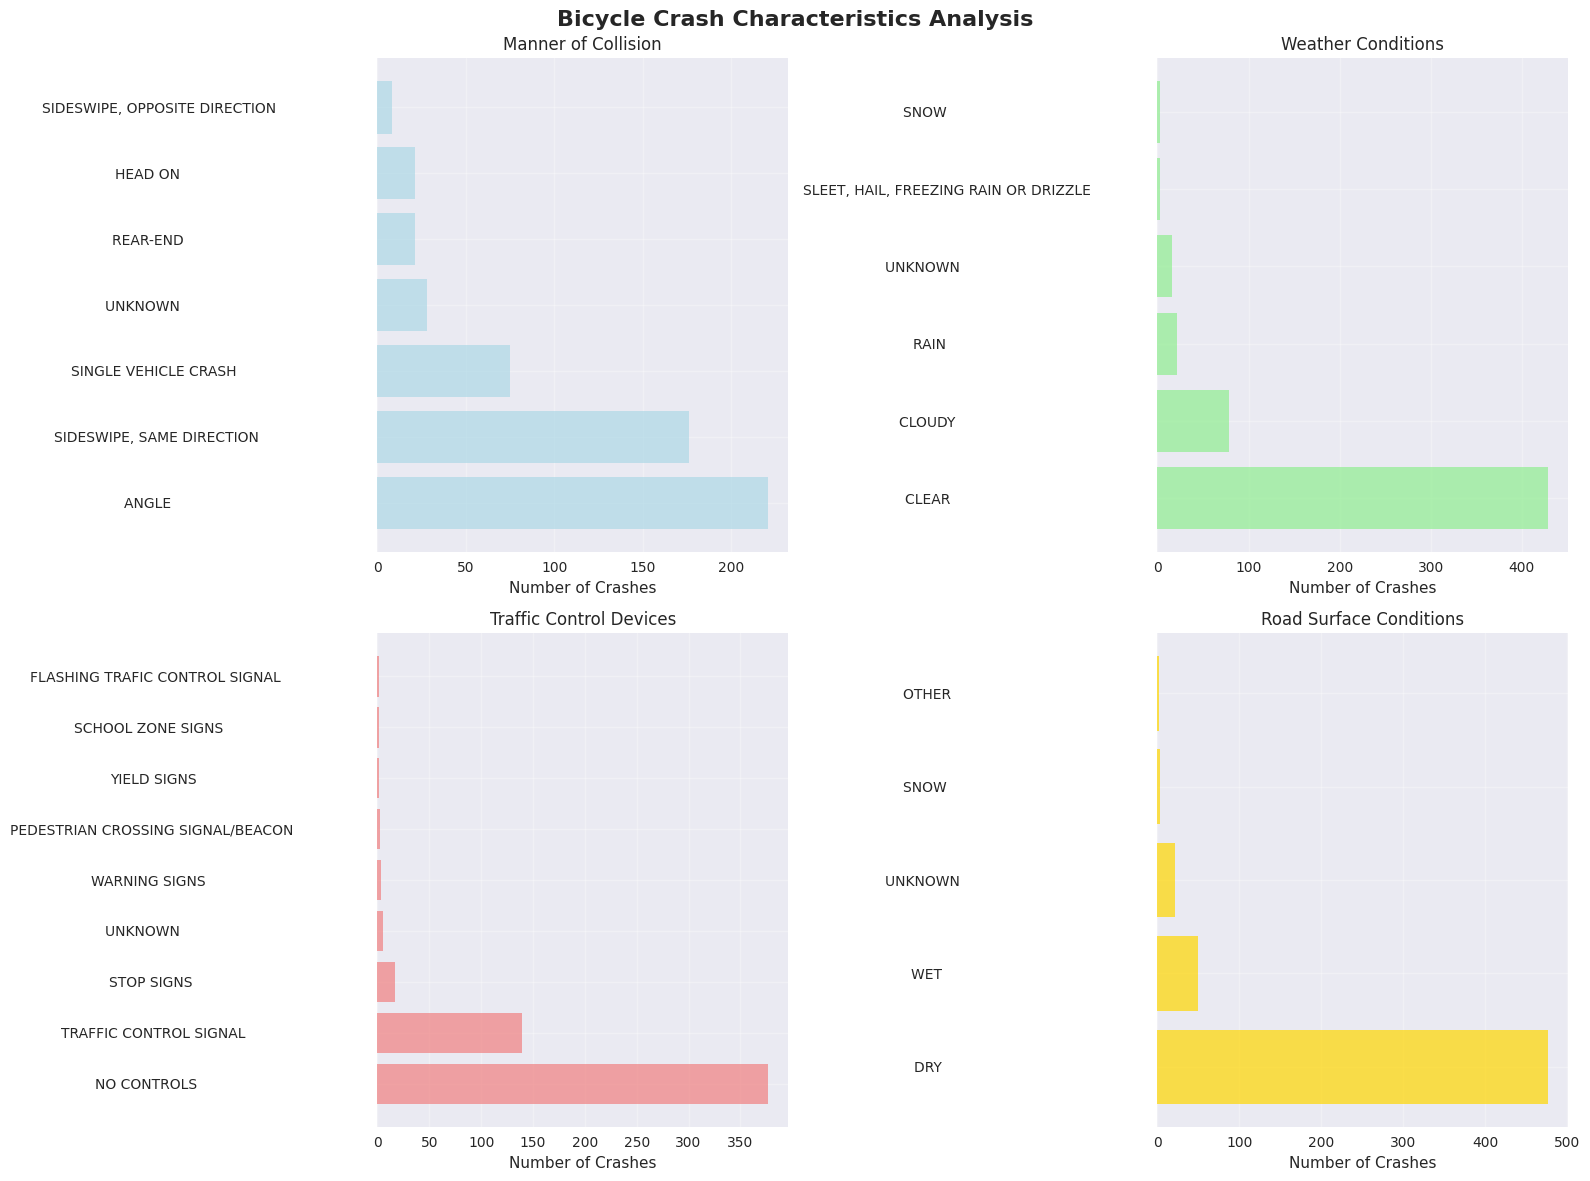

CRASH CHARACTERISTICS SUMMARY:
Most common collision type: ANGLE                                              (221 crashes, 40.0%)
Most common weather: CLEAR                                              (429 crashes, 77.7%)
Most common traffic control: NO CONTROLS                                        (377 crashes, 68.3%)
Most common road surface: DRY                                                (477 crashes, 86.4%)


In [7]:

# Analyze crash characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Bicycle Crash Characteristics Analysis', fontsize=16, fontweight='bold')

# 1. Manner of Collision
collision_types = df['Manner of Collision'].value_counts()
axes[0, 0].barh(collision_types.index, collision_types.values, color='lightblue', alpha=0.7)
axes[0, 0].set_title('Manner of Collision')
axes[0, 0].set_xlabel('Number of Crashes')
axes[0, 0].grid(True, alpha=0.3)

# 2. Weather Conditions
weather_conditions = df['Weather Condition 1'].value_counts()
axes[0, 1].barh(weather_conditions.index, weather_conditions.values, color='lightgreen', alpha=0.7)
axes[0, 1].set_title('Weather Conditions')
axes[0, 1].set_xlabel('Number of Crashes')
axes[0, 1].grid(True, alpha=0.3)

# 3. Traffic Control Devices
traffic_control = df['Traffic Control Device Type'].value_counts()
axes[1, 0].barh(traffic_control.index, traffic_control.values, color='lightcoral', alpha=0.7)
axes[1, 0].set_title('Traffic Control Devices')
axes[1, 0].set_xlabel('Number of Crashes')
axes[1, 0].grid(True, alpha=0.3)

# 4. Road Surface Conditions
road_surface = df['Road Surface Condition'].value_counts()
axes[1, 1].barh(road_surface.index, road_surface.values, color='gold', alpha=0.7)
axes[1, 1].set_title('Road Surface Conditions')
axes[1, 1].set_xlabel('Number of Crashes')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("CRASH CHARACTERISTICS SUMMARY:")
print("="*40)
print(f"Most common collision type: {collision_types.index[0]} ({collision_types.iloc[0]} crashes, {collision_types.iloc[0]/len(df)*100:.1f}%)")
print(f"Most common weather: {weather_conditions.index[0]} ({weather_conditions.iloc[0]} crashes, {weather_conditions.iloc[0]/len(df)*100:.1f}%)")
print(f"Most common traffic control: {traffic_control.index[0]} ({traffic_control.iloc[0]} crashes, {traffic_control.iloc[0]/len(df)*100:.1f}%)")
print(f"Most common road surface: {road_surface.index[0]} ({road_surface.iloc[0]} crashes, {road_surface.iloc[0]/len(df)*100:.1f}%)")


## 5. High-Risk Intersections Analysis


HIGH-RISK INTERSECTIONS ANALYSIS:
Intersections with 3+ bicycle crashes: 37
Total crashes at high-risk intersections: 406
Percentage of all crashes: 73.6%

TOP 10 HIGH-RISK INTERSECTIONS:
137 crashes - MASSACHUSETTS AVENUE
    Peak: Wednesday at 11:00
    Most common: SIDESWIPE, SAME DIRECTION                         
    Weather: CLEAR                                             

35 crashes - CAMBRIDGE STREET
    Peak: Friday at 17:00
    Most common: SIDESWIPE, SAME DIRECTION                         
    Weather: CLEAR                                             

29 crashes - BROADWAY
    Peak: Wednesday at 9:00
    Most common: SIDESWIPE, SAME DIRECTION                         
    Weather: CLEAR                                             

25 crashes - HAMPSHIRE STREET
    Peak: Wednesday at 9:00
    Most common: SIDESWIPE, SAME DIRECTION                         
    Weather: CLEAR                                             

14 crashes - ALBANY STREET_AND_MASSACHUSETTS AVENUE


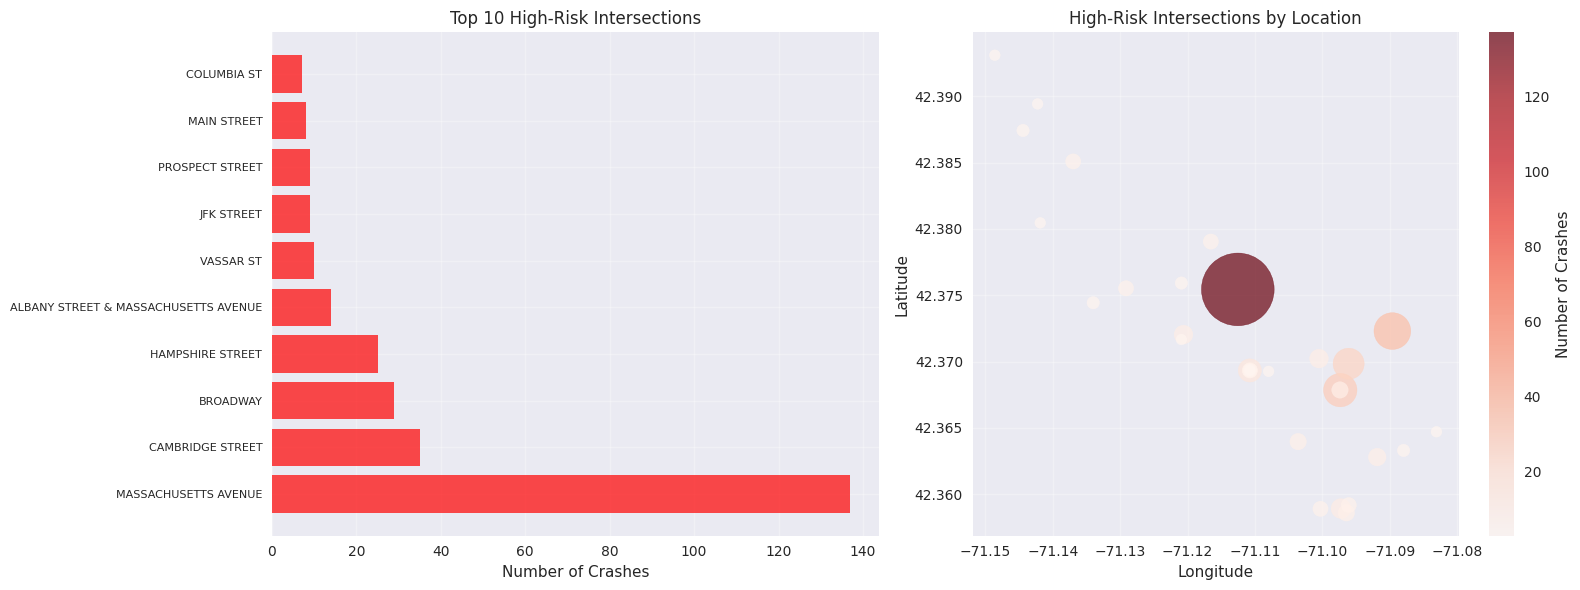

In [11]:
# Analyze high-risk intersections
print("HIGH-RISK INTERSECTIONS ANALYSIS:")
print("="*40)

# Get intersections with multiple crashes
intersection_crash_counts = df['Intersection_ID'].value_counts()
high_risk_intersections = intersection_crash_counts[intersection_crash_counts >= 3]

print(f"Intersections with 3+ bicycle crashes: {len(high_risk_intersections)}")
print(f"Total crashes at high-risk intersections: {high_risk_intersections.sum()}")
print(f"Percentage of all crashes: {high_risk_intersections.sum()/len(df)*100:.1f}%")

# Create detailed analysis of top intersections
intersection_analysis = []
for intersection in high_risk_intersections.index:
    intersection_crashes = df[df['Intersection_ID'] == intersection]
    
    intersection_analysis.append({
        'Intersection': intersection,
        'Crash_Count': len(intersection_crashes),
        'Latitude': intersection_crashes['Latitude'].mean(),
        'Longitude': intersection_crashes['Longitude'].mean(),
        'First_Crash': intersection_crashes['Date Time'].min(),
        'Last_Crash': intersection_crashes['Date Time'].max(),
        'Most_Common_Collision': intersection_crashes['Manner of Collision'].mode().iloc[0] if len(intersection_crashes) > 0 else None,
        'Most_Common_Weather': intersection_crashes['Weather Condition 1'].mode().iloc[0] if len(intersection_crashes) > 0 else None,
        'Peak_Hour': intersection_crashes['Hour'].mode().iloc[0] if len(intersection_crashes) > 0 else None,
        'Peak_Day': intersection_crashes['Day of Week'].mode().iloc[0] if len(intersection_crashes) > 0 else None
    })

intersection_df = pd.DataFrame(intersection_analysis)
intersection_df = intersection_df.sort_values('Crash_Count', ascending=False)

print(f"\nTOP 10 HIGH-RISK INTERSECTIONS:")
print("="*40)
for idx, row in intersection_df.head(10).iterrows():
    print(f"{row['Crash_Count']:2d} crashes - {row['Intersection']}")
    print(f"    Peak: {row['Peak_Day']} at {row['Peak_Hour']}:00")
    print(f"    Most common: {row['Most_Common_Collision']}")
    print(f"    Weather: {row['Most_Common_Weather']}")
    print()

# Create visualization of high-risk intersections
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of top intersections
top_10_intersections = intersection_df.head(10)
ax1.barh(range(len(top_10_intersections)), top_10_intersections['Crash_Count'], color='red', alpha=0.7)
ax1.set_yticks(range(len(top_10_intersections)))
ax1.set_yticklabels([name.replace('_AND_', ' & ') for name in top_10_intersections['Intersection']], fontsize=8)
ax1.set_xlabel('Number of Crashes')
ax1.set_title('Top 10 High-Risk Intersections')
ax1.grid(True, alpha=0.3)

# Scatter plot of intersections by coordinates
scatter = ax2.scatter(intersection_df['Longitude'], intersection_df['Latitude'], 
                     s=intersection_df['Crash_Count']*20, 
                     c=intersection_df['Crash_Count'], 
                     cmap='Reds', alpha=0.7)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('High-Risk Intersections by Location')
ax2.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Number of Crashes')

plt.tight_layout()
plt.show()
